# Homework1 : Car Fuel


## Day 2

In [352]:
• 交差検証、ホールドアウト法などで汎化性能を確認する
• 欠測値と異常値を確認し、適切に処理する
• DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する
• 交差検証によるパラメータチューニングを行う
• パラメータチューニング後のモデルによって、精度および結果の評価を行う
• その他、精度の向上ができるような処理に取り組み、精度を上げる

• できたところまでをNotebookでまとめ、宿題として提出する

• 前回から取り組んだ内容・工夫、精度がどのように変化したかのコメントを
Notebookに含めること

SyntaxError: invalid character in identifier (<ipython-input-352-6a7fc101f978>, line 1)

## about this project

### Context
I am driving always the same car and i take almost always the same route. However, at the gas station i like to change the gas type; between SP98 (sold as "Super plus" sometimes) and SP95 E10 (This is, "super" gas with 10% Alcohol). E10 is sold for 1,38€; SP98 is sold for 1,46€; per liter.

From my feeling i would say that my car consumes a lot more with E10. From the data, what can we derive there? I challenge you to partial out the factor "E10 gas" and tell me how much my car really consumes more with it.

I applied my own basic linear regression on it and had as a result that it consumes 0.4 liters more with E10 gas. Linear regressions have the disadvantage that you can only really use them if the features are independent.

I challenge you to predict the consumption depending on the gas type!


### Content
Since a few months, i write down the data of my car's display after each ride; while regularly changing the gas type.

In the file, you will find the displayed distance (km); the consume (L/100km); the average speed (km/h), the temperature i had inside (°C), the temperature outside (°C), anything special that happened, if it was raining, if the air condition was on, if it was sunny enough that the car felt warm when i started it... and yes - the gas type i was using. I have also two columns saying how much and which gas type I was buying. Careful with those. The numbers don't add exactly up, because I note only the rides that occur under certain conditions: If the car was not cooling down enough to have another independent measure from the one before, i don't note it.

I started writing down the data in November, changed to SP98 in winter, and back to E10 in spring. Apart from that, the data is rather clean as i was doing my own project on it already.

### Acknowledgements
Thanks to Victor Chernozhukov who was planting this idea in my head, even if it took some years until i finally acted on it. :-)

### Inspiration
I was using a linear regression to partial out the influence of the gas type. The gas type is truly independent from the rest of the variables, so it should be possible without problem. However - depending on how i engineer the other features, the result is between 0.4 and 0.8 liters per 100km influence. A large, single-feature-depending difference usually is a hint for lots of covariance between the features; meaning in turn that linear regression might not be the best tool here.

In [353]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

df_flue = pd.read_csv("data/measurements.csv")
# "refill liters,refill gas" are ignored.
df_flue = df_flue.filter(items=['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 
                                'gas_type','AC','rain', 'sun'])

# Replace the type
for k in ["consume","temp_inside", "distance"]:
    df_flue[k] = df_flue[k].str.replace(",", ".").astype(float)

df_e10 = df_flue[df_flue['gas_type'].str.contains('E10')].dropna(how='any')
df_sp98 = df_flue[df_flue['gas_type'].str.contains('SP98')].dropna(how='any')

df_flue.describe()


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000


In [354]:
df_e10.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,21.095541,4.950955,43.566879,21.917197,10.031847,0.044586,0.101911,0.070064
std,20.495185,0.897976,14.154946,0.659854,6.379475,0.207053,0.303499,0.256071
min,1.700000,3.700000,14.000000,21.000000,-5.000000,0.000000,0.000000,0.000000
25%,12.000000,4.400000,35.000000,21.500000,6.000000,0.000000,0.000000,0.000000
50%,15.400000,4.800000,42.000000,21.500000,9.000000,0.000000,0.000000,0.000000
75%,21.100000,5.300000,51.000000,22.500000,14.000000,0.000000,0.000000,0.000000
max,130.300000,10.800000,88.000000,25.000000,27.000000,1.000000,1.000000,1.000000


In [355]:
df_sp98.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,18.866667,4.906849,40.803653,21.938356,12.278539,0.105023,0.141553,0.091324
std,24.625703,1.133679,13.302507,1.201906,7.393901,0.307285,0.349389,0.288730
min,1.300000,3.300000,16.000000,19.000000,-3.000000,0.000000,0.000000,0.000000
25%,11.800000,4.200000,32.000000,21.500000,7.000000,0.000000,0.000000,0.000000
50%,14.200000,4.700000,40.000000,22.000000,11.000000,0.000000,0.000000,0.000000
75%,18.200000,5.200000,48.000000,22.000000,17.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000


MAE = 0.649
E10 : w0 = 0.000, w1 = -0.244, 二乗誤差 = 0.000


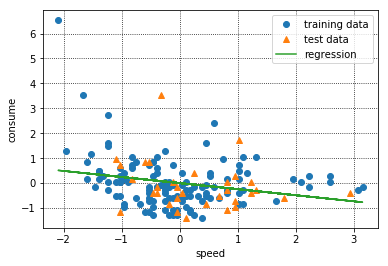

Cross Validation MAE = 0.683


In [356]:

def holdout(test_size, gas_type, X, y):
    X = X.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

    regr = LinearRegression(fit_intercept=False)
    regr.fit(X_train, y_train)
    
    # 学習用データに対する予測を実行
    y_pred_train = regr.predict(X_train)

    # 学習データに対するMAEを計算（訓練誤差の評価）
    mae = mean_absolute_error(y_train, y_pred_train)
#    print("MAE = %s"%round(mae,3) )
    
    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)

    # テストデータに対するMAEを計算（汎化誤差の評価）
    mae = mean_absolute_error(y_test, y_pred_test)
    print("MAE = %s"%round(mae,3) )

    e_yest_sklearn = regr.intercept_ + regr.coef_[0][0] * e_x
    squared_error = 0.5 * np.sum( (e_yest_sklearn - e_y) ** 2)
#     print("{} {} {} {}".format(type(gas_type), type(regr.intercept_), type(regr.coef_[0]), type(squared_error)))
    print("{} : w0 = {:.3f}, w1 = {:.3f}, 二乗誤差 = {:.3f}".format(
        gas_type, regr.intercept_, regr.coef_[0][0], squared_error))
    return X_train, X_test, y_train, y_test, y_pred_test, y_pred_train

def showGraph(X_train, X_test, y_train, y_test, y_pred_test, y_pred_train):
    plt.plot(X_train, y_train, 'o', label='training data')
    plt.plot(X_test, y_test, '^', label='test data')
    plt.ylabel("consume")
    plt.xlabel("speed")
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(X_train, y_pred_train, label='regression')
    plt.legend(loc='best')
    plt.show()

def crossValidation(x,y):
    X = x.reshape(-1,1) # scikit-learnに入力するために整形
    n_split = 5 # グループ数を設定（今回は5分割）

    cross_valid_mae = 0
    split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] #学習用データ
        X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
        # 学習用データを使って線形回帰モデルを学習
        regr = LinearRegression(fit_intercept=False)
        regr.fit(X_train, y_train)

        # テストデータに対する予測を実行
        y_pred_test = regr.predict(X_test)
    
        # テストデータに対するMAEを計算
        mae = mean_absolute_error(y_test, y_pred_test)
#        print("Fold %s"%split_num)
#        print("MAE = %s"%round(mae, 3))
#        print()
    
        cross_valid_mae += mae #後で平均を取るためにMAEを加算
        split_num += 1

        # MAEの平均値を最終的な汎化誤差値とする
        final_mae = cross_valid_mae / n_split
    print("Cross Validation MAE = %s"%round(final_mae, 3))

def standalization(d):
    df = pd.DataFrame(d,dtype=float)
    stdsc = StandardScaler()
    return stdsc.fit_transform(df.values)
        
def run(gas_type, X, Y):
    X = standalization(X)
    Y = standalization(Y)
    result = list(holdout(0.2, gas_type, X, Y))
    showGraph(*result)
    crossValidation(X, Y)

# Do not run with multiple parameter at train_test_split. 
# 
# error "ValueError: Found input variables with inconsistent numbers of samples: [314, 157]"
#
# 倍になっている？
# x_keys = ["speed", "temp_inside"]
x_keys = ["speed"]
run("E10", df_e10[x_keys].values, df_e10[["consume"]].values)


MAE = 0.578
SP98 : w0 = 0.000, w1 = -0.272, 二乗誤差 = 0.000


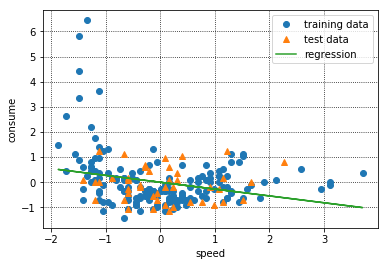

Cross Validation MAE = 0.651


In [357]:
run("SP98", df_sp98["speed"].values, df_sp98["consume"].values)

alpha : 0
alpha : 0.001
alpha : 0.01
alpha : 0.1
alpha : 1.0
alpha : 10.0
alpha : 100.0
alpha : 1000.0


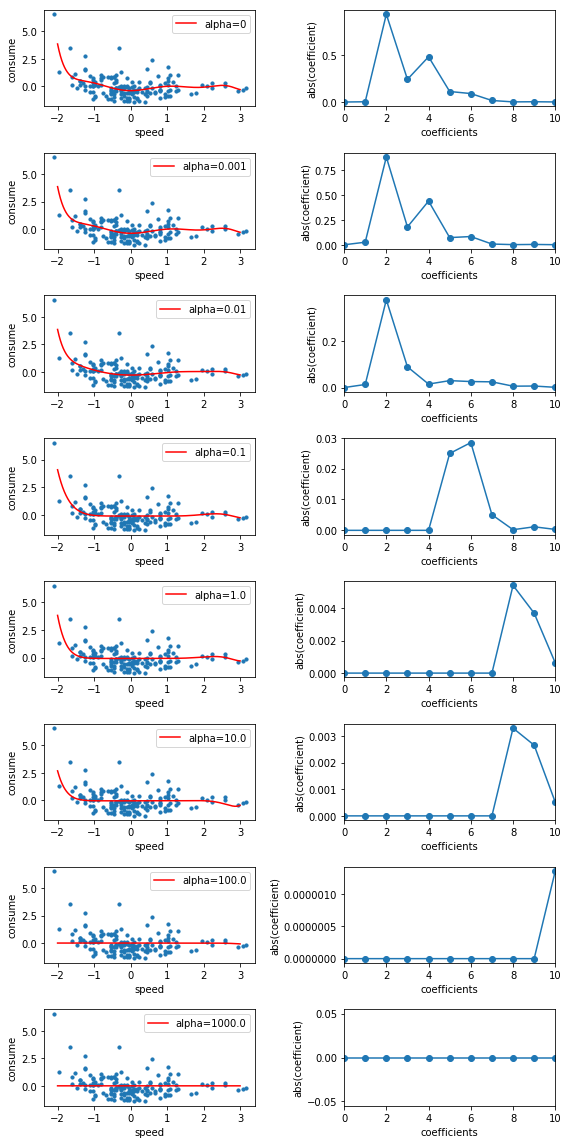

In [373]:

x_plot = np.linspace(-2, 3, 10000)
n_samples = 10

def plot_approximation(X, y, est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    # ax.plot(x_plot, f(x_plot), color='green')
    ax.scatter(X, y, s=10)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylabel('consume')
    ax.set_xlabel('speed')
    ax.legend(loc='upper right')  #, fontsize='small')

def plot_coefficients(est,degree, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((0, degree))

def run2(X, y):    
    X = standalization(X)
    y = standalization(y)

    alphas = [0, 1e-3, 1e-2, 1e-1,  1e+0, 1e+1, 1e+2,  1e+3   ]
    degree = 10
    fig, ax_rows = plt.subplots(len(alphas), 2, figsize=(8, 2 * len(alphas)))
    for ax_row, alpha in zip(ax_rows, alphas):
            print(f"alpha : {alpha}")
            ax_left, ax_right = ax_row
        #    el = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1e2)
        #   est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            la = Lasso(alpha=alpha,max_iter=1e5)
            est = make_pipeline(PolynomialFeatures(degree), la)
            est.fit(X, y)
            plot_approximation(X, y, est, ax_left, label='alpha=%r' % alpha)
            plot_coefficients(est,degree, ax_right, label='Lasso(alpha=%r) coefficients' % alpha, yscale=None)
    plt.tight_layout()

# The key is only speed for viaualization.
x_keys = ["speed"]
run2(df_e10[x_keys].values, df_e10["consume"].values)


alpha : 0
alpha : 0.001
alpha : 0.01
alpha : 0.1
alpha : 1.0
alpha : 10.0
alpha : 100.0
alpha : 1000.0


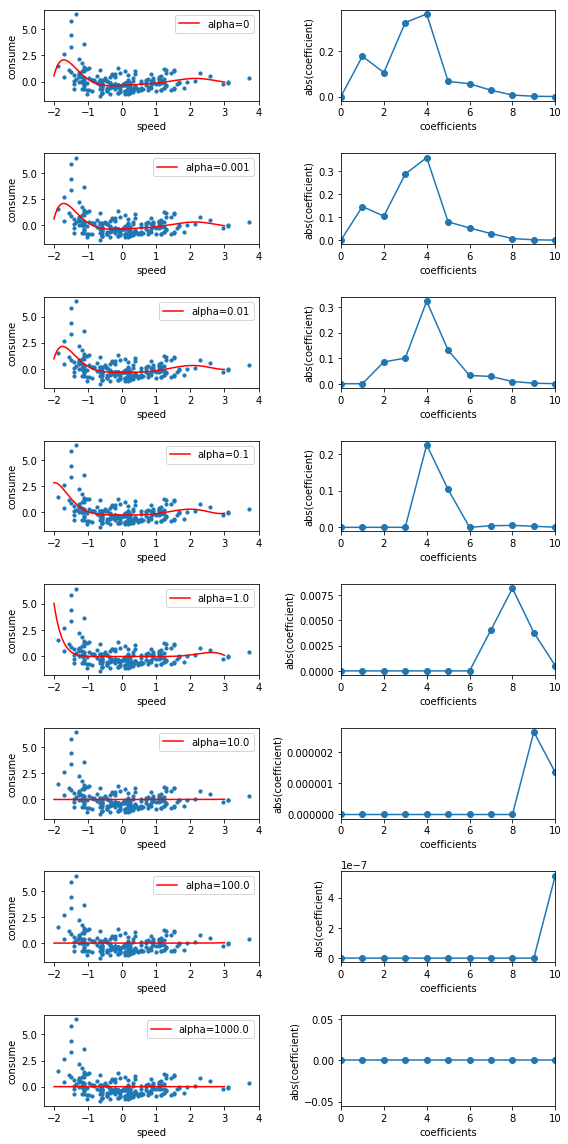

In [374]:
run2(df_sp98[x_keys].values, df_sp98["consume"].values)


In [376]:
def run3(X, y):    
    X = standalization(X)
    y = standalization(y)

    alphas = [0, 1e-3, 1e-2, 1e-1,  1e+0, 1e+1, 1e+2,  1e+3   ]
    l1_ratios = [0, 0.25, 0.5, 0.75, 1.0] 
    degree = 3
    n_split = 5
    
    for ll_ratio in l1_ratios:
        for alpha in alphas:
            split_num = 0
            cross_valid_mae = 0
            # algo = Lasso(alpha=alpha,max_iter=1e5)
            algo = ElasticNet(alpha=alpha, l1_ratio=ll_ratio, max_iter=1e5)

            for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
                X_train, y_train = X[train_idx], y[train_idx] #学習用データ
                X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

                est = make_pipeline(PolynomialFeatures(degree), algo)
                est.fit(X_train, y_train)

                # テストデータに対する予測を実行
                y_pred_test = est.predict(X_test)

                # テストデータに対するMAEを計算
                mae = mean_absolute_error(y_test, y_pred_test)

                cross_valid_mae += mae #後で平均を取るためにMAEを加算
                split_num += 1

            # MAEの平均値を最終的な汎化誤差値とする
            final_mae = cross_valid_mae / n_split
            print("Cross Validation MAE = %s (alpha : %e, ll_ratio : %s)"% (round(final_mae, 3), alpha ,round(ll_ratio, 2)))
            # print("Cross Validation MAE = %s (alpha : %e)"% (round(final_mae, 3), alpha))

x_keys = ["speed", "temp_inside", "temp_outside", "AC", "rain", "sun"]
run3(df_e10[x_keys].values, df_e10["consume"].values)


Cross Validation MAE = 4.409 (alpha : 0.000000e+00, ll_ratio : 0)
Cross Validation MAE = 2.99 (alpha : 1.000000e-03, ll_ratio : 0)
Cross Validation MAE = 1.315 (alpha : 1.000000e-02, ll_ratio : 0)
Cross Validation MAE = 0.915 (alpha : 1.000000e-01, ll_ratio : 0)
Cross Validation MAE = 0.774 (alpha : 1.000000e+00, ll_ratio : 0)
Cross Validation MAE = 0.71 (alpha : 1.000000e+01, ll_ratio : 0)
Cross Validation MAE = 0.704 (alpha : 1.000000e+02, ll_ratio : 0)
Cross Validation MAE = 0.705 (alpha : 1.000000e+03, ll_ratio : 0)
Cross Validation MAE = 4.409 (alpha : 0.000000e+00, ll_ratio : 0.25)
Cross Validation MAE = 2.803 (alpha : 1.000000e-03, ll_ratio : 0.25)
Cross Validation MAE = 0.985 (alpha : 1.000000e-02, ll_ratio : 0.25)
Cross Validation MAE = 0.771 (alpha : 1.000000e-01, ll_ratio : 0.25)
Cross Validation MAE = 0.744 (alpha : 1.000000e+00, ll_ratio : 0.25)
Cross Validation MAE = 0.707 (alpha : 1.000000e+01, ll_ratio : 0.25)
Cross Validation MAE = 0.707 (alpha : 1.000000e+02, ll_ratio

In [377]:
run3(df_sp98[x_keys].values, df_sp98["consume"].values)

Cross Validation MAE = 2.559 (alpha : 0.000000e+00, ll_ratio : 0)
Cross Validation MAE = 2.784 (alpha : 1.000000e-03, ll_ratio : 0)
Cross Validation MAE = 1.517 (alpha : 1.000000e-02, ll_ratio : 0)
Cross Validation MAE = 0.792 (alpha : 1.000000e-01, ll_ratio : 0)
Cross Validation MAE = 0.67 (alpha : 1.000000e+00, ll_ratio : 0)
Cross Validation MAE = 0.647 (alpha : 1.000000e+01, ll_ratio : 0)
Cross Validation MAE = 0.648 (alpha : 1.000000e+02, ll_ratio : 0)
Cross Validation MAE = 0.68 (alpha : 1.000000e+03, ll_ratio : 0)
Cross Validation MAE = 2.559 (alpha : 0.000000e+00, ll_ratio : 0.25)
Cross Validation MAE = 2.886 (alpha : 1.000000e-03, ll_ratio : 0.25)
Cross Validation MAE = 1.212 (alpha : 1.000000e-02, ll_ratio : 0.25)
Cross Validation MAE = 0.625 (alpha : 1.000000e-01, ll_ratio : 0.25)
Cross Validation MAE = 0.647 (alpha : 1.000000e+00, ll_ratio : 0.25)
Cross Validation MAE = 0.69 (alpha : 1.000000e+01, ll_ratio : 0.25)
Cross Validation MAE = 0.69 (alpha : 1.000000e+02, ll_ratio :